In [1]:
import numpy as np
from pymatgen import Molecule
from pymatgen.io.qchem import QcTask, QcOutput
import math

# Extract dihedrals and energy from qchem files

In [2]:
import os 
import re

In [3]:
def get_energy_dihedral(directory):
    dihedral, energy = [], []
    for f in os.listdir(directory):
        if ".qcout" in f:
            if ".orig" not in f:
                output = QcOutput('{d}/{f}'.format(d=directory,f=f))
                qchem_in = output.data[-1]['input']
                try:
                    energy.append(output.final_energy)
                except IndexError:
                    energy.append('no energy') 
                constraints = qchem_in.params['opt']
                for l in constraints:
                    if 'tors' in l:
                        dihedral.append(l[len(l)-1])
    return dihedral, energy

In [4]:
dihedral, energy = get_energy_dihedral('./pt_cust_dft_full')

# Plot dihedral potential

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def eV_to_kJmol(energy):
    kJ_mol = [(i*96.48537559152172) for i in energy]
    return kJ_mol

In [7]:
def eV_to_kcalmol(energy):
    kcal_mol = [(i*23.06035) for i in energy]
    return kcal_mol

In [8]:
kJmol_energy = eV_to_kJmol(energy)

In [9]:
def relative_energy(energy):
    minimum = min(energy, key=float)
    rel_energy = [i - minimum for i in energy]
    return rel_energy

In [10]:
rel_eV_energy = relative_energy(energy)

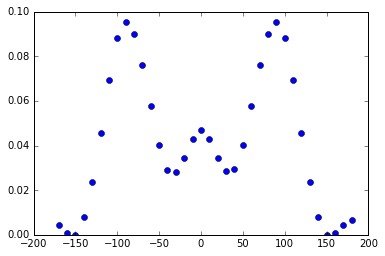

In [11]:
plt.plot(dihedral, rel_eV_energy, 'o')

In [12]:
#out_0 = QcOutput('./pt_cust_dft_full/pt_dft_0.0.qcout')
#final_struc_0 = out_0.final_structure
#final_struc_0.to(filename='final_structure_0.xyz', fmt='xyz')

# Fitting dihedral curve

In [13]:
from scipy.optimize import curve_fit

In [14]:
# Ryckaert_Bellemans dihedral potential function
def RB_potential(x, a, b, c, d, e, f):
    return (a*1.0 + b*np.cos(x*np.pi/180.0) + c*(np.cos(x*np.pi/180.0)**2) + d*(np.cos(x*np.pi/180.0)**3) + e*(np.cos(x*np.pi/180.0)**4) + f*(np.cos(x*np.pi/180.0)**5))

In [15]:
#rel_kcal_mol_energy = relative_energy(eV_to_kcalmol(energy))
#All calcs in relative eVs

In [16]:
popt, pcov = curve_fit(RB_potential,dihedral,rel_eV_energy)

In [17]:
popt

array([ 0.09589618,  0.00937093, -0.21725121,  0.00549039,  0.14653387,
        0.00507763])

In [18]:
# create list of angles and corresponding energies
angles = np.linspace(-170, 180, 1080)
RB_energy = [RB_potential(angle, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]) for angle in angles]

In [19]:
#sort lists so line plot makes sense
#di_energy_list = zip(angles, RB_energy)
#sorted_di_energy = sorted(di_energy_list, key=lambda tup: tup[0])
#sorted_dihedral, sorted_RB_energy = zip(*sorted_di_energy)

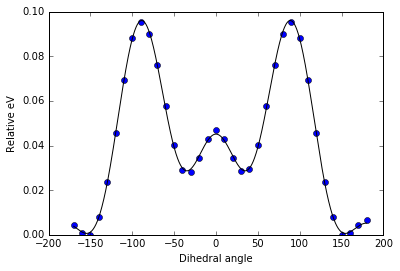

In [20]:
plt.figure()
plt.plot(dihedral, rel_eV_energy, 'o', angles, RB_energy, 'black')
plt.xlabel('Dihedral angle')
plt.ylabel('Relative eV')
plt.show()

# Probabilities using Bolzmann distribution

In [21]:
kb_eVpK = 8.6173324 * 10**-5

In [22]:
kbT700 = kb_eVpK * 700.0

In [23]:
kbT300 = kb_eVpK * 300.0

In [24]:
RB_energy[0], kbT700

(0.0038499718951866399, 0.060321326800000005)

In [25]:
np.exp(-RB_energy[0] / kbT700)

0.93816973692573624

In [26]:
# normalization 
boltz_factor_700 = [np.exp(-energy / kbT700) for energy in RB_energy]
normalize_val = sum(boltz_factor_700)

In [27]:
normalize_val

593.6871656219015

In [28]:
prob_700 = [(np.exp(-energy / kbT700) / normalize_val) for energy in RB_energy]

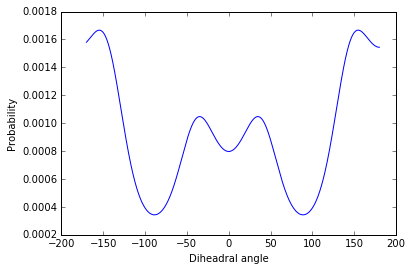

In [29]:
plt.figure()
plt.plot(angles, prob_700)
plt.xlabel('Diheadral angle')
plt.ylabel('Probability')
plt.show()

# Map random numbers between 0-1 to dihedral angles

In [30]:
cum_prob = [sum(prob_700[0:prob_i]) for prob_i in range(len(prob_700))]

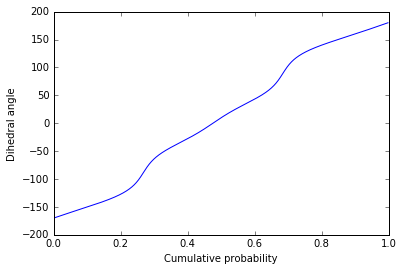

In [31]:
plt.figure()
plt.plot(cum_prob, angles)
plt.xlabel('Cumulative probability')
plt.ylabel('Dihedral angle')
plt.show()

In [32]:
angle_map = zip(cum_prob, angles)

In [33]:
from scipy.interpolate import interp1d

In [34]:
angle_map = interp1d(cum_prob, angles, kind='cubic')

In [35]:
angle_map([.89334223, .24234980234])

array([ 158.57852851, -109.23452336])

# Build PT all trans backbone

In [36]:
ring_len = 2.548
bond_len = 1.480
pi = np.pi

In [37]:
n = 11
chain = np.zeros(((2*n),3))
len(chain)

22

In [38]:
# relative positions r-b1-r-b2-r-b1-r-b2-r ...
r = [ring_len,0,0]
b1 = [bond_len*np.cos(pi/12.0), -bond_len*np.sin(pi/12.0), 0]
b2 = [bond_len*np.cos(pi/12.0), bond_len*np.sin(pi/12.0), 0]

In [39]:
bond_iter = 'b1'
for pos in range(1,(2*n),1):
    #print pos
    #print bond_iter
    if pos % 2 != 0:
        chain[pos] = chain[pos-1] + r
        continue
    elif pos % 2 == 0:
        if bond_iter == 'b1':
            chain[pos] = chain[pos-1] + b1
            bond_iter = 'b2'
        elif bond_iter == 'b2':
            chain[pos] = chain[pos-1] + b2
            bond_iter = 'b1'

In [40]:
chain

array([[  0.        ,   0.        ,   0.        ],
       [  2.548     ,   0.        ,   0.        ],
       [  3.97757022,  -0.38305219,   0.        ],
       [  6.52557022,  -0.38305219,   0.        ],
       [  7.95514045,   0.        ,   0.        ],
       [ 10.50314045,   0.        ,   0.        ],
       [ 11.93271067,  -0.38305219,   0.        ],
       [ 14.48071067,  -0.38305219,   0.        ],
       [ 15.91028089,   0.        ,   0.        ],
       [ 18.45828089,   0.        ,   0.        ],
       [ 19.88785111,  -0.38305219,   0.        ],
       [ 22.43585111,  -0.38305219,   0.        ],
       [ 23.86542134,   0.        ,   0.        ],
       [ 26.41342134,   0.        ,   0.        ],
       [ 27.84299156,  -0.38305219,   0.        ],
       [ 30.39099156,  -0.38305219,   0.        ],
       [ 31.82056178,   0.        ,   0.        ],
       [ 34.36856178,   0.        ,   0.        ],
       [ 35.79813201,  -0.38305219,   0.        ],
       [ 38.34613201,  -0.38305

In [41]:
chain[:,0]

array([  0.        ,   2.548     ,   3.97757022,   6.52557022,
         7.95514045,  10.50314045,  11.93271067,  14.48071067,
        15.91028089,  18.45828089,  19.88785111,  22.43585111,
        23.86542134,  26.41342134,  27.84299156,  30.39099156,
        31.82056178,  34.36856178,  35.79813201,  38.34613201,
        39.77570223,  42.32370223])

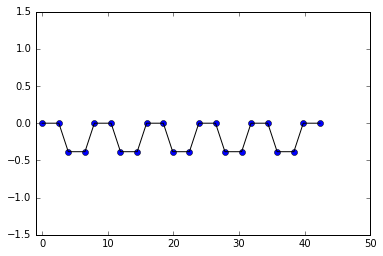

In [42]:
plt.plot(chain[:,0], chain[:,1], 'o', chain[:,0], chain[:,1], 'black')
plt.xlim(-1,50)
plt.ylim(-1.5,1.5)
#plt.axes().set_aspect('equal', 'datalim')
plt.show()

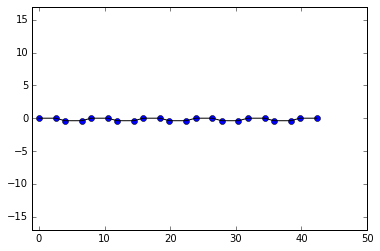

In [43]:
plt.plot(chain[:,0], chain[:,1], 'o', chain[:,0], chain[:,1], 'black')
plt.xlim(-1,50)
plt.ylim(-1.5,1.5)
plt.axes().set_aspect('equal', 'datalim')
plt.show()

In [44]:
np.linalg.norm(chain[1]-chain[2])

1.4800000000000002

In [45]:
from pymatgen.util.coord_utils import get_angle

In [46]:
get_angle(chain[0]-chain[1], chain[2]-chain[1])

165.0

In [47]:
def build_chain(n):
    chain = np.zeros(((2*n),3))
    ring_len = 2.548
    bond_len = 1.480
    pi = np.pi
    r = [ring_len,0,0]
    b1 = [bond_len*math.cos(pi/12.0), -bond_len*math.sin(pi/12.0), 0]
    b2 = [bond_len*math.cos(pi/12.0), bond_len*math.sin(pi/12.0), 0]
    bond_iter = 'b1'
    for pos in range(1,(2*n),1):
        if pos % 2 != 0:
            chain[pos] = chain[pos-1] + r
            continue
        elif pos % 2 == 0:
            if bond_iter == 'b1':
                chain[pos] = chain[pos-1] + b1
                bond_iter = 'b2'
            elif bond_iter == 'b2':
                chain[pos] = chain[pos-1] + b2
                bond_iter = 'b1'
    return chain

In [48]:
%timeit build_chain(50)

1000 loops, best of 3: 268 µs per loop


# Rotation Matrix

In [49]:
#calc and return unit vector of two pts, pts must numpy format
def unit_vector(pt1, pt2):
    line = pt1 - pt2
    return line/math.sqrt((np.dot(line, line)))

In [50]:
#rotate a point around an arbitray unit vector
#http://inside.mines.edu/fs_home/gmurray/ArbitraryAxisRotation/
def point_rotation(pt, angle_degree, unit_vector, origin=None):
    angle = np.pi - (angle_degree * (np.pi / 180.0))
    x, y, z = pt[0], pt[1], pt[2]
    u, v, w = unit_vector[0], unit_vector[1], unit_vector[2]
    if origin is not None:
        a, b, c = origin[0], origin[1], origin[2]
    else:
        a,b,c = 0.0, 0.0, 0.0
    new_x = ((a*(v**2 + w**2) - u*(b*v + c*w - u*x - v*y - w*z))*(1 - math.cos(angle)) 
             + x*math.cos(angle) 
             + (-c*v + b*w - w*y + v*z)*math.sin(angle))
    
    new_y = ((b*(u**2 + w**2) - v*(a*u + c*w - u*x - v*y - w*z))*(1 - math.cos(angle)) 
             + y*math.cos(angle)
             + (c*u - a*w + w*x - u*z)*math.sin(angle))
    
    new_z = ((c*(u**2 + v**2) - w*(a*u + b*v - u*x - v*y - w*z))*(1 - math.cos(angle)) 
             + z*math.cos(angle)
             + (-b*u + a*v - v*x + u*y)*math.sin(angle))
    return np.array([new_x, new_y, new_z])
    

# Generate dihedral set

In [51]:
dihedral_set = angle_map(np.random.uniform(0,1, size=10))

# Tangent - tangent correlation function

In [52]:
#def corr_fn(tan1, tan2):
    

# Build and relax a single chain

In [53]:
def relax_chain(chain_len, dihedral_set):
    #dihedral_set = angle_map(np.random.uniform(0,1, size=(chain_len-1)))
    chain = build_chain(chain_len)
    end_to_end = [0.0, 2.548]
    pos_i = 1
    for angle in dihedral_set:
        uv = unit_vector(chain[pos_i], chain[pos_i+1])
        for pos_j in range(pos_i+2, len(chain), 1):
            chain[pos_j] = point_rotation(chain[pos_j], angle, uv, origin=chain[pos_i])
        pos_i += 2
        end_to_end.append(math.sqrt(np.dot(chain[pos_i]-chain[0], chain[pos_i]-chain[0])))
    return chain, np.array(end_to_end)

In [54]:
test_chain, a1 = relax_chain(5, angle_map(np.random.uniform(0,1, size=(5-1))))
test_chain

array([[  0.        ,   0.        ,   0.        ],
       [  2.548     ,   0.        ,   0.        ],
       [  3.97757022,  -0.38305219,   0.        ],
       [  6.51121652,  -0.43662094,   0.26470896],
       [  7.92468028,  -0.11367887,   0.56174196],
       [ 10.08927484,   0.72622762,   1.61121398],
       [ 11.1047278 ,   1.34575438,   2.49180575],
       [ 13.03114472,   1.77850584,   4.10237957],
       [ 14.1773466 ,   1.64457451,   5.02903142],
       [ 16.40162678,   1.89970476,   6.24549772]])

In [55]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

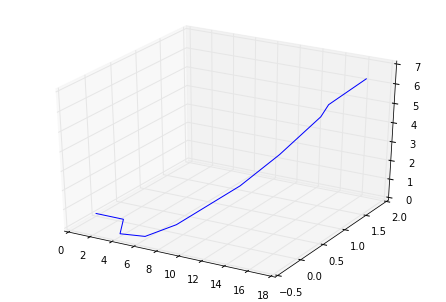

In [56]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(test_chain[:,0], test_chain[:,1], test_chain[:,2])

In [57]:
names = ["C" for i in range(len(chain))]

In [58]:
chain_mol = Molecule(names, chain)

In [59]:
chain_mol

Molecule Summary
Site: C (0.0000, 0.0000, 0.0000)
Site: C (2.5480, 0.0000, 0.0000)
Site: C (3.9776, -0.3831, 0.0000)
Site: C (6.5256, -0.3831, 0.0000)
Site: C (7.9551, 0.0000, 0.0000)
Site: C (10.5031, 0.0000, 0.0000)
Site: C (11.9327, -0.3831, 0.0000)
Site: C (14.4807, -0.3831, 0.0000)
Site: C (15.9103, 0.0000, 0.0000)
Site: C (18.4583, 0.0000, 0.0000)
Site: C (19.8879, -0.3831, 0.0000)
Site: C (22.4359, -0.3831, 0.0000)
Site: C (23.8654, 0.0000, 0.0000)
Site: C (26.4134, 0.0000, 0.0000)
Site: C (27.8430, -0.3831, 0.0000)
Site: C (30.3910, -0.3831, 0.0000)
Site: C (31.8206, 0.0000, 0.0000)
Site: C (34.3686, 0.0000, 0.0000)
Site: C (35.7981, -0.3831, 0.0000)
Site: C (38.3461, -0.3831, 0.0000)
Site: C (39.7757, 0.0000, 0.0000)
Site: C (42.3237, 0.0000, 0.0000)

In [60]:
import dihedral_tools

In [61]:
dihedral_tools.get_dihedral(chain_mol, [1,2,3,4])

-180.0

In [62]:
dihedral_tools.get_dihedral(chain_mol, [3,4,5,6])

-180.0

In [63]:
dihedral_tools.get_dihedral(chain_mol, [5,6,7,8])

-180.0

In [64]:
dihedral_tools.get_dihedral(chain_mol, [7,8,9,10])

-180.0

# Sample ensemble of chains

In [98]:
def sample_chains(chain_len, dihedral_set, chain_num):
    ave_ete = np.zeros(chain_len+1)
    for chain_i in range(chain_num):
        chain, end_to_end = relax_chain(chain_len, dihedral_set)
        ave_ete += end_to_end
    ave_ete /= chain_num
    return ave_ete

In [66]:
a = np.array([1,3])

In [67]:
%timeit np.append(a,2)

The slowest run took 33.50 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.96 µs per loop


In [68]:
b = [1,3]

In [69]:
%timeit np.array(b.append(2))

The slowest run took 28.09 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 458 ns per loop


In [93]:
te = np.array([2.0,3.0,4.0])
te /= 2.0
te

array([ 1. ,  1.5,  2. ])

In [99]:
chain_len = 25
dihedral_set = angle_map(np.random.uniform(0,1, size=(chain_len-1)))
ave_ete_test = sample_chains(chain_len, dihedral_set, 1000)

NameError: name 'ave_ete_test' is not defined